# Boston Housing - A regression problem
In this notebook we give a quick introduction working with pailab's repository and tools where we use the boston housing regression problem as use case.

In [1]:
#import all things you need to get startes
import time
import pandas as pd
import logging as logging
import pprint
import plotly
plotly.offline.init_notebook_mode(connected=True)

# Here start the repository specific imports
import pailab.ml_repo.memory_handler as memory_handler
from pailab import RepoInfoKey, MeasureConfiguration, MLRepo, DataSet, MLObjectType, FIRST_VERSION, LAST_VERSION
from pailab.job_runner.job_runner import SimpleJobRunner, JobState, SQLiteJobRunner

#You may set the loglevel and log-format here. 
logging.basicConfig(level=logging.FATAL)

# Read the data
As an example machine learning task to ilustrate the way of working with the repository we use the Boston housing data from the  [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/index.php) where we have applied some preprocessing. The data consists of house prices together with the house features `'RM'`, `'LSTAT'`, and `'PTRATIO'`:
- `'RM'` is the average number of rooms among homes in the neighborhood.
- `'LSTAT'` is the percentage of homeowners in the neighborhood considered "lower class" (working poor).
- `'PTRATIO'` is the ratio of students to teachers in primary and secondary schools in the neighborhood.
We just read the csv-file containing the data (also in the repository) into a pandas dataframe.

In [2]:
data = pd.read_csv('housing.csv')

# Create a new repository
We first create a new repository for our task. The repository is the central key around all functionality is built. Similar to a repository used for source control in classical software development it contains all data and algorithms needed for the machine learning task. The repository needs storages for 
- scripts containing the machine learning algorithms and interfaces,
- numerical objects such as arrays and matrices representing data, e.g. input data, data from the valuation of the models,
- json documents representing parameters, e.g. training parameter, model parameter.

To keep things simple, we just start using in memory storages. Note that the used memory interfaces are except for testing and playing around not be the first choice, since when ending the session, everything will be lost...

In addition to the storages the repository needs a reference to a JobRunner which the platform can use to execute machine learning jobs. For this example we use the most simple one, executing everything sequential in the same thread, the repository runs in.

In [3]:
# setting up the repository
config = {'user': 'test_user',
      'workspace': 'c:/temp',
      'repo_store': 
      {
          'type': 'memory_handler',  
          'config': {}
      },
      'numpy_store':
      {
          'type': 'memory_handler',
          'config':{}
      },
      'job_runner':
      {
          'type': 'simple',
          'config': {
              'throw_job_error': True
          }
      }
    }
ml_repo = MLRepo( user = 'test_user', config=config)

## Add a tree
To navigate in a simple way over all objects, one can add a so-called tree to the repository. The tree allows one to use auto completion to acces objcts and respectiv methods.

In [4]:
from pailab.tools.tools import MLTree
MLTree.add_tree(ml_repo)

## Adding data
The data in the repository is handled by two different data objects:
- RawData is the object containing real data.
- DataSet is the object conaining the logical data, i.e. a reference to a RawData object together with a specification, which data from the RawData will be used. Here, one can specify a fixed version of the underlying RawData object (then changes to the RawData will not affect the derived DataSet) or a fixed or floating subset of the RawData by defininga start and endindex cutting the derived data just out of the original data.

Normally one will add RawData and then define DataSets which are used to train or test a model which is exactly the way shown in the following.

In [5]:
# Add RawData. A convenient way to add RawData is simply to use the method add on the raw_data collection.
# This method just takes a pandas dataframe and the specification, which columns belong to the input 
#and which to the targets.
ml_repo.tree.raw_data.add('boston_housing', data,  
                          input_variables=['RM', 'LSTAT', 'PTRATIO'], 
                          target_variables = ['MEDV'])
# based on the raw data we now define training and test sets
ml_repo.tree.training_data.add('sample1', ml_repo.tree.raw_data.boston_housing(), 0, 300)
ml_repo.tree.test_data.add('sample2', ml_repo.tree.raw_data.boston_housing(), 301, None)

In [6]:
ml_repo.tree.training_data.sample1.history()

{'6f0bdc58-771a-11e9-9fe9-fc084a6691eb': {'RepoInfoKey.AUTHOR': 'test_user',
  'RepoInfoKey.COMMIT_DATE': '2019-05-15 16:05:02.741410',
  'RepoInfoKey.COMMIT_MESSAGE': ''}}

When creating the DataSet we have to set two important informations for the repository, given as a dictionary:
- The object name. Each object in the repository needs to have a unique name in the repository.
- The object type which gives. In our example here we say that we specify that the DataSet are training and test data. Note that on can have only one training data object pre repository while the repository can obtain many different test data sets.

Some may wonder what is now stored in *version_list*.
** Adding an object (independent if it is a data object or some other object such as a parameter), the object gets a version number and no object will be removed, adding just adds a new version.** The add method returns a dictionary of the object names together with their version number.

## Adding a model
The next step to do machine learning would be to define a model which will be used in the repository. A model consists of the following pieces
- a skript where the code for the model valuation is defined together with the function name of the evaluation method
- a skript where the code for the model training is defined together with th function nam of the training method
- a model parameter object defining the model parameter and which must have implemented the correct interface so that it can be used within the repository (see the documentation on integrating new objects, normally there is not more to do then just simply add *@repo_object_init()* to the line above your *__init__* method)
- a training parameter object defining training parameters (such as number of optimization steps etc.), if necessary for your algorithms (this oen is optional)

** SKLearn models as an example**

We do not have to define the pieces defined above, if we use the sklearn module. Instead we can use the pailab.externals.sklearn module interfacing 
the sklearn package so that this can be used within the repository. This interface provides a simple method (add_model) to add an arbitrary sklearn model as a model which can be handled by the repository. This method adds a bunch of repo objects to the repository (according to the pieces described above):
- An object defining the function to be called to evaluate the model
- An object defining the function to be called to train the model
- An object defining the model
- An object defining the model parameter
For the following we just use a DecisionTree as our model.

In [7]:
import pailab.externals.sklearn_interface as sklearn_interface
from sklearn.tree import DecisionTreeRegressor
sklearn_interface.add_model(ml_repo, DecisionTreeRegressor(), model_param={'max_depth': 5})

## Train the model
Now, model taining is very simple, since you have defined training and testing data as well as  methods to value and fit your model and the model parameter.
So, you can just call *run_training* on the repository, and the training is perfomred automatically.
The training job is executed via the JobRunner you specified setting up the repository. All method of the repository involving jobs return the job id when adding the job to the JobRunner so that you can control the status of the task and see if it sucessfully finished.

In [8]:
job_id = ml_repo.run_training() 
print(job_id)
job_info = ml_repo._job_runner.get_info(job_id[0], job_id[1])

('DecisionTreeRegressor/jobs/training', '6f2d615c-771a-11e9-9230-fc084a6691eb')


## Run evaluation
To measure errors and to provide plots the model must be evaluated on all test and training datasets.

In [9]:
job_id = ml_repo.run_evaluation()
# print information about the job
info = ml_repo._job_runner.get_info(job_id[0][0], job_id[0][1]) 
print(str(info))

test_user, successfully_finished, started 2019-05-15 16:05:03.028993, finished 2019-05-15 16:05:03.028993


## Add and compute measures

In [10]:
ml_repo.add_measure(MeasureConfiguration.MAX)
ml_repo.add_measure(MeasureConfiguration.R2)

In [11]:
job_ids = ml_repo.run_measures()

In [12]:
ml_repo.tree.models.DecisionTreeRegressor.measures.sample1.max.load()
print(str(ml_repo.tree.models.DecisionTreeRegressor.measures.sample1.max.obj.value))

223200.0


Note that the steps
- *run_evaluation*
- *run_measures*

are not necessary if *run_training* is called with the keyword argument *run_descendants=True*. 
In This case the repository would have automatically triggered all evaluations and measurement calculations automatically.

# Working with the repository
This section shows how one can work with the audit and revision functionality of the repository.

In [13]:
for k in MLObjectType:
    names = ml_repo.get_names(k.value)
    for n in names: 
        print(n + '\t  ' + k.value)

raw_data/boston_housing	  RAW_DATA
DecisionTreeRegressor/eval/sample2	  RAW_DATA
DecisionTreeRegressor/eval/sample1	  RAW_DATA
sample1	  TRAINING_DATA
sample2	  TEST_DATA
DecisionTreeRegressor/model_param	  MODEL_PARAM
train_sklearn	  TRAINING_FUNCTION
eval_sklearn	  MODEL_EVAL_FUNCTION
DecisionTreeRegressor	  MODEL
DecisionTreeRegressor/model	  CALIBRATED_MODEL
CommitInfo	  COMMIT_INFO
repo_mapping	  MAPPING
DecisionTreeRegressor/measure/sample2/max	  MEASURE
DecisionTreeRegressor/measure/sample2/r2	  MEASURE
DecisionTreeRegressor/measure/sample1/max	  MEASURE
DecisionTreeRegressor/measure/sample1/r2	  MEASURE
measure_config	  MEASURE_CONFIGURATION
DecisionTreeRegressor/jobs/training	  JOB
DecisionTreeRegressor/model/jobs/eval_job/sample2	  JOB
DecisionTreeRegressor/model/jobs/eval_job/sample1	  JOB
DecisionTreeRegressor/model/jobs/measure/sample2/max	  JOB
DecisionTreeRegressor/model/jobs/measure/sample2/r2	  JOB
DecisionTreeRegressor/model/jobs/measure/sample1/max	  JOB
DecisionTree

Repository information such as version number, author, date of change are attached to the repo objects and can simply be retrieved:

In [14]:
ml_repo.tree.models.DecisionTreeRegressor.measures.sample1.r2.load()
pprint.pprint(ml_repo.tree.models.DecisionTreeRegressor.measures.sample1.r2.obj.repo_info.get_dictionary())

{'author': 'test_user',
 'big_objects': [],
 'category': 'MEASURE',
 'classname': 'pailab.ml_repo.repo_objects.Measure',
 'commit_date': '2019-05-15 16:05:03.148836',
 'commit_message': 'computing  measure r2 on data sample1',
 'description': None,
 'modification_info': {'DecisionTreeRegressor': '6f2130a0-771a-11e9-8fbb-fc084a6691eb',
                       'DecisionTreeRegressor/eval/sample1': '6f385a27-771a-11e9-8d40-fc084a6691eb',
                       'DecisionTreeRegressor/model': '6f2dfd88-771a-11e9-9853-fc084a6691eb',
                       'DecisionTreeRegressor/model_param': '6f21309f-771a-11e9-b8d7-fc084a6691eb',
                       'sample1': '6f0bdc58-771a-11e9-9fe9-fc084a6691eb'},
 'modifiers': {},
 'name': 'DecisionTreeRegressor/measure/sample1/r2',
 'version': '6f4a076c-771a-11e9-ac49-fc084a6691eb'}


In [15]:
ml_repo.tree.models.DecisionTreeRegressor.measures.sample1.r2.history()

{'6f4a076c-771a-11e9-ac49-fc084a6691eb': {'RepoInfoKey.AUTHOR': 'test_user',
  'RepoInfoKey.COMMIT_DATE': '2019-05-15 16:05:03.148836',
  'RepoInfoKey.COMMIT_MESSAGE': 'computing  measure r2 on data sample1'}}

The commits can also be queried and printed. 

In [16]:
for k in ml_repo.get_commits():
    pprint.pprint(k.to_dict())

{'author': 'test_user',
 'message': 'data raw_data/boston_housing added to repository',
 'objects': {'raw_data/boston_housing': '6f0b3f28-771a-11e9-9aa6-fc084a6691eb'},
 'time': datetime.datetime(2019, 5, 15, 16, 5, 2, 737386)}
{'author': 'test_user',
 'message': '',
 'objects': {'sample1': '6f0bdc58-771a-11e9-9fe9-fc084a6691eb'},
 'time': datetime.datetime(2019, 5, 15, 16, 5, 2, 741410)}
{'author': 'test_user',
 'message': '',
 'objects': {'sample2': '6f0bdc59-771a-11e9-bde0-fc084a6691eb'},
 'time': datetime.datetime(2019, 5, 15, 16, 5, 2, 741410)}
{'author': 'test_user',
 'message': 'add function eval_sklearn of category MODEL_EVAL_FUNCTION to the '
            'repo',
 'objects': {'eval_sklearn': '6f2094de-771a-11e9-95e1-fc084a6691eb'},
 'time': datetime.datetime(2019, 5, 15, 16, 5, 2, 881193)}
{'author': 'test_user',
 'message': 'add function train_sklearn of category TRAINING_FUNCTION to the '
            'repo',
 'objects': {'train_sklearn': '6f21309e-771a-11e9-97bd-fc084a6691eb'

## Labeling models
There is the possibility to label a certain version of a model. The label can then be used to access the model instead of the version number. It is vry useful to
compare e.g. the current productive model (labeld e.g. 'prod') against other model versions. abels are supported by many functions and tools and make life much easier. So the consistency checks only check for the latest and labeled models if there are changes make a rerun of training/evaluation/measures needed. Also som figures will automatically highlight the results belonging to labeled versions.

Let us label the latest model version in the repo.

In [17]:
ml_repo.tree.models.DecisionTreeRegressor.set_label('prod',version = LAST_VERSION, message='we found our first production model')

## Tests
It is possible to define model tests.
### Regressiontests
Regressiontests compare measuresments on the repositories dataset of a model to th measurements of labeled reference model.

In [18]:
import pailab.tools.tests
reg_test = pailab.tools.tests.RegressionTestDefinition(reference='prod', models=None, data=None, labels=None, measures=None,  tol=1e-3)
reg_test.repo_info.name='reg_test'
#reg_test.repo_info.category = MLObjectType.TEST_DEFINITION
ml_repo.add(reg_test, message='regression test definition')
#ml_repo.tree.models.DecisionTreeRegressor.measures.sample1.

'6f8bdbda-771a-11e9-adff-fc084a6691eb'

In [19]:
ml_repo.run_tests()

[('DecisionTreeRegressor/tests/reg_test/sample2',
  '6f946470-771a-11e9-8792-fc084a6691eb'),
 ('DecisionTreeRegressor/tests/reg_test/sample1',
  '6f95007a-771a-11e9-b459-fc084a6691eb')]

## Consistency checks
Pailab's *checks*-submodule provides functionality to check for consistency and quality issues as well as for outstanding tasks (such as rerunning a training after the training set has been changed).

### Model consistency
There are different checks to test model consistency such as if the tests of a model are up to date and succeeded or if the latest model is trained on the latest trainin data. All model tests are performed for **labeled** models and the latest model only.
In our first example we change a model parameter but do not train for a new model version wih this parameter.

The following checks are performed:
- Is the latest model calibrated on the latest parameters and training data
- Are all labeled models (including latest model) evaluated on the latest available training and test data
- Are all measures of all labeled models computed on the latest data
- Have all tests been run on the labeled models

In [20]:
param = ml_repo.get('DecisionTreeRegressor/model_param')
param.sklearn_params['max_depth'] = 2
version = ml_repo.add(param)
print(param.sklearn_params)

{'criterion': 'mse', 'max_depth': 2, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': None, 'splitter': 'best'}


After we have changed the model parameter, we use the *tools* submodules *check_model* method for open tasks/inconsistencies. This method can be called for a certain model or also for a lbeled model. If nothing is specified, all labeled models will be checked.
Applying the method to the latest model we see that the output shows that the models last version has been calibrated using a different model parameter version then the current version. 

In [21]:
import pailab.tools.checker as checker
results = checker.run(ml_repo)
pprint.pprint(results)

[{'DecisionTreeRegressor/model:last': {'latest model version not on latest inputs': {'DecisionTreeRegressor/model_param': {'latest version': '6f9f5d2c-771a-11e9-9d9a-fc084a6691eb',
                                                                                                                           'modifier version': '6f21309f-771a-11e9-b8d7-fc084a6691eb'}}}}]


Note that the labeled model would not show an issue. Only the latest model is affected by this change (it is the definition of latest model that it has been calibrated on latest inputs).

We can resolve this issue by simply training the model again (now on the new training data set).

In [22]:
ml_repo.run_training()

('DecisionTreeRegressor/jobs/training', '6fb2427e-771a-11e9-9096-fc084a6691eb')

Note that the solution to simply retrain introduced new issues: The model has not yet been evaluated and no measures have been computed. (If we would have set **run_descendants=False** as argument, the preceding steps would have also been performed and the issues would not have been present).

In [23]:
results = checker.run(ml_repo)
pprint.pprint(results)

[{'DecisionTreeRegressor/model:last': {'evaluations missing': {'sample1': '6f0bdc58-771a-11e9-9fe9-fc084a6691eb',
                                                               'sample2': '6f0bdc59-771a-11e9-bde0-fc084a6691eb'},
                                       'measures not calculated': {'DecisionTreeRegressor/measure/sample1/max',
                                                                   'DecisionTreeRegressor/measure/sample1/r2',
                                                                   'DecisionTreeRegressor/measure/sample2/max',
                                                                   'DecisionTreeRegressor/measure/sample2/r2'}}}]


In [24]:
ml_repo.run_evaluation(run_descendants=True)# we use run_descendants so that the issues with th measures are resolved too

[('DecisionTreeRegressor/model/jobs/eval_job/sample2',
  '6fc5c3d2-771a-11e9-9f39-fc084a6691eb'),
 ('DecisionTreeRegressor/model/jobs/eval_job/sample1',
  '6fc83402-771a-11e9-8069-fc084a6691eb')]

In [25]:
results = checker.run(ml_repo)
pprint.pprint(results)

[]


### Checking training and test data consistency
There may be also data inconsistencies, so for example the training and test data overlap. The **check_data** methods performs such a test.

Let us first add a new test data set which overlaps with the training data

In [26]:
ml_repo.tree.test_data.add('sample3', ml_repo.tree.raw_data.boston_housing(), 0, 50)

In [27]:
checker.run(ml_repo)

[{'DecisionTreeRegressor/model:last': {'evaluations missing': {'sample3': '6fdb1940-771a-11e9-8803-fc084a6691eb'},
   'measures not calculated': {'DecisionTreeRegressor/measure/sample3/max',
    'DecisionTreeRegressor/measure/sample3/r2'}}},
 {'prod': {'evaluations missing': {'sample3': '6fdb1940-771a-11e9-8803-fc084a6691eb'},
   'measures not calculated': {'DecisionTreeRegressor/measure/sample3/max',
    'DecisionTreeRegressor/measure/sample3/r2'}}},
 {'sample3': {'training and test data overlap': {'sample1': '6f0bdc58-771a-11e9-9fe9-fc084a6691eb',
    'sample3': '6fdb1940-771a-11e9-8803-fc084a6691eb'}}}]

### Checking usage of RawData
The check_data method includes also a check if all RawData is used in DataSets or if there is some unused data.

### Checking test status
There is also a check if all latest tests have been applied to all labeled models and all latest models.

In [28]:
checker.Tests.run(ml_repo)

{'DecisionTreeRegressor/model:6fb37a90-771a-11e9-9e21-fc084a6691eb': {'DecisionTreeRegressor/tests/reg_test/sample1': 'Test for model DecisionTreeRegressor/model, version 6fb37a90-771a-11e9-9e21-fc084a6691eb on latest data sample1 missing.',
  'DecisionTreeRegressor/tests/reg_test/sample2': 'Test for model DecisionTreeRegressor/model, version 6fb37a90-771a-11e9-9e21-fc084a6691eb on latest data sample2 missing.',
  'DecisionTreeRegressor/tests/reg_test/sample3': 'Test for model DecisionTreeRegressor/model, version 6fb37a90-771a-11e9-9e21-fc084a6691eb on latest data sample3 missing.'},
 'DecisionTreeRegressor/model:prod': {'DecisionTreeRegressor/tests/reg_test/sample1': "Test for model DecisionTreeRegressor/model, version 6f2dfd88-771a-11e9-9853-fc084a6691eb on latest data sample1 failed, details: {'max': {'reference_value': 223200.0, 'value': 223200.0}, 'r2': {'reference_value': 0.92140837838916367, 'value': 0.92140837838916367}}",
  'DecisionTreeRegressor/tests/reg_test/sample2': "Test

In [29]:
ml_repo.run_evaluation()
ml_repo.run_measures()
ml_repo.run_tests()
pprint.pprint(checker.Tests.run(ml_repo))

{'DecisionTreeRegressor/model:6fb37a90-771a-11e9-9e21-fc084a6691eb': {'DecisionTreeRegressor/tests/reg_test/sample1': 'Test '
                                                                                                                      'for '
                                                                                                                      'model '
                                                                                                                      'DecisionTreeRegressor/model, '
                                                                                                                      'version '
                                                                                                                      '6fb37a90-771a-11e9-9e21-fc084a6691eb '
                                                                                                                      'on '
                                                             

## Easy access to repo objects and names
Since the names are chosen equally to a directory structure (with subdirectories) they may be long and difficult to remember (especially the order). And even if one remembers the long names, it is a lot of work to type them.

If you now type the objects name followd by a '.' by pressing tab you will see the possible next solutions makin it very easy to 'browse' to the object's name you have in mind. By using '()' operator you get a list of names below th current naming level, and in addition you can filter the names by giving a string: Only names containing this string are put into the list.

In [30]:
ml_repo.tree.models.DecisionTreeRegressor.model_param.load()

In [31]:
ml_repo.tree.models.DecisionTreeRegressor.model_param.obj.repo_info.get_dictionary()

{'author': 'test_user',
 'big_objects': [],
 'category': 'MODEL_PARAM',
 'classname': 'pailab.externals.sklearn_interface.SKLearnModelParam',
 'commit_date': '2019-05-15 16:05:03.708087',
 'commit_message': '',
 'description': None,
 'modification_info': {},
 'modifiers': {},
 'name': 'DecisionTreeRegressor/model_param',
 'version': '6f9f5d2c-771a-11e9-9d9a-fc084a6691eb'}

## Append RawData
One can append data to the RawData object. The repository manages which objects are affected by appending data and directly updates these objects.

In [32]:
train_data = ml_repo.get_training_data(full_object = False)
print(train_data.repo_info[RepoInfoKey.NAME] +': ' +str(train_data))
test_data = ml_repo.get_names(MLObjectType.TEST_DATA)
for k in test_data:
    t = ml_repo.get(k)
    print(str(t)+ ' Version: ' + str(t.repo_info[RepoInfoKey.VERSION]))

sample1: {'raw_data': 'raw_data/boston_housing', 'start_index': 0, 'end_index': 300, 'raw_data_version': 'last', 'x_coord_names': ['RM', 'LSTAT', 'PTRATIO'], 'y_coord_names': ['MEDV'], 'n_data': 489}
{'raw_data': 'raw_data/boston_housing', 'start_index': 301, 'end_index': None, 'raw_data_version': 'last', 'x_coord_names': ['RM', 'LSTAT', 'PTRATIO'], 'y_coord_names': ['MEDV'], 'n_data': 489} Version: 6f0bdc59-771a-11e9-bde0-fc084a6691eb
{'raw_data': 'raw_data/boston_housing', 'start_index': 0, 'end_index': 50, 'raw_data_version': 'last', 'x_coord_names': ['RM', 'LSTAT', 'PTRATIO'], 'y_coord_names': ['MEDV'], 'n_data': 489} Version: 6fdb1940-771a-11e9-8803-fc084a6691eb


In [33]:
from numpy import array
ml_repo.tree.raw_data.boston_housing.append(x_data = array([[ 6.575, 4.98, 15.3]]), y_data =array([[504000.0]]))

In [34]:
print(train_data.repo_info[RepoInfoKey.NAME] +': ' +str(train_data))
for k in test_data:
    t = ml_repo.get(k)
    print(str(t) + ' Version: ' + str(t.repo_info[RepoInfoKey.VERSION]))

sample1: {'raw_data': 'raw_data/boston_housing', 'start_index': 0, 'end_index': 300, 'raw_data_version': 'last', 'x_coord_names': ['RM', 'LSTAT', 'PTRATIO'], 'y_coord_names': ['MEDV'], 'n_data': 489}
{'raw_data': 'raw_data/boston_housing', 'start_index': 301, 'end_index': None, 'raw_data_version': '702e9afa-771a-11e9-a3c4-fc084a6691eb', 'x_coord_names': ['RM', 'LSTAT', 'PTRATIO'], 'y_coord_names': ['MEDV'], 'n_data': 490} Version: 702e9afb-771a-11e9-a57a-fc084a6691eb
{'raw_data': 'raw_data/boston_housing', 'start_index': 0, 'end_index': 50, 'raw_data_version': 'last', 'x_coord_names': ['RM', 'LSTAT', 'PTRATIO'], 'y_coord_names': ['MEDV'], 'n_data': 490} Version: 6fdb1940-771a-11e9-8803-fc084a6691eb


In [35]:
results = checker.run(ml_repo)
print(results)

[{'DecisionTreeRegressor/model:last': {'evaluations missing': {'sample2': '702e9afb-771a-11e9-a57a-fc084a6691eb'}}}, {'prod': {'evaluations missing': {'sample2': '702e9afb-771a-11e9-a57a-fc084a6691eb'}}}, {'sample3': {'training and test data overlap': {'sample3': '6fdb1940-771a-11e9-8803-fc084a6691eb', 'sample1': '6f0bdc58-771a-11e9-9fe9-fc084a6691eb'}}}]


# Repo-Analysis
Having parameters, evaluations, measures in one place enables out of the box analysis- and plotting functionality. The submodule *plot* provides automated, standardized plots.

In [36]:
import pailab.analysis.plot as plot

## Plotting
### Plot errors and measures

In [37]:
# create more different model params etc. to make the repo more interesting ;-)
for j in range(2):
    training_data = ml_repo.get(ml_repo.tree.training_data.sample1())
    training_data.end_index += 50
    ml_repo.add(training_data, message='add 50 datapoints to end_index')
    for i in range(6,12):
        #print(i)
        param = ml_repo.get(ml_repo.tree.models.DecisionTreeRegressor.model_param())
        param.sklearn_params['max_depth'] = i
        version = ml_repo.add(param)
        ml_repo.add(param)
        ml_repo.run_training()
        ml_repo.run_evaluation()
        ml_repo.run_measures()
        if j == 1 and i==6:
            ml_repo.tree.models.DecisionTreeRegressor.set_label('prod', message='')
        if j == 1 and i==8:
            ml_repo.tree.models.DecisionTreeRegressor.set_label('candidate', message='')

#### Plot error measure vs parameter

In [38]:
import pailab.analysis.plot_helper as plt_helper
import pailab.analysis.plot as plot
plot.measure_by_parameter(ml_repo, ml_repo.tree.models.DecisionTreeRegressor.measures('max'), 'max_depth', data_versions=LAST_VERSION)
#ml_repo.models.DecisionTreeRegressor.measures('r2')

#### Plot error vs input variable

In [39]:
plot.scatter_model_error(ml_repo, ml_repo.tree.models.DecisionTreeRegressor.model(), ml_repo.tree.test_data.sample2(), 'PTRATIO')

#### Plot histogram of model error

In [40]:
plot.histogram_model_error(ml_repo, ml_repo.tree.models.DecisionTreeRegressor.model(), ml_repo.tree.test_data.sample2())

### Plot data

In [41]:
plot.histogram_data(ml_repo, {ml_repo.tree.test_data.sample2() :['last'], ml_repo.tree.training_data.sample1(): ['first','last']}, x_coordinate = 'PTRATIO') #, y_coordinate='MEDV')

## Plot dependency graph

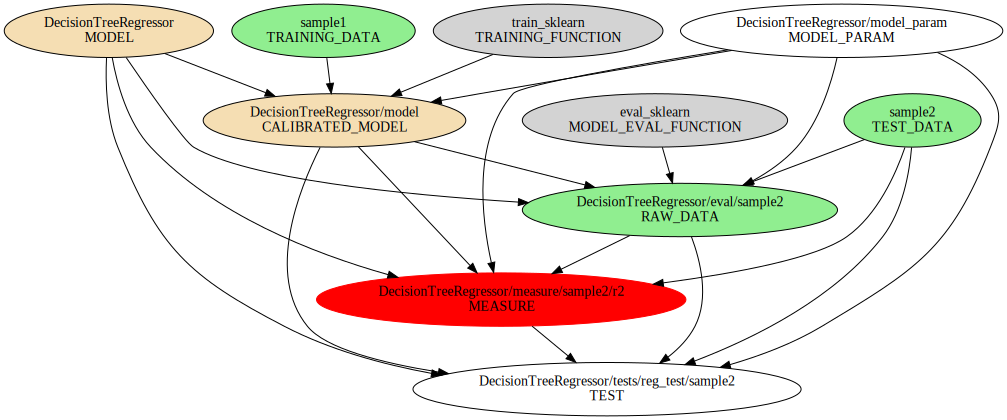

In [42]:
# Uncomment the following lines to plot the dependencies. Note that this functionality needs graphviz to be installed 
#from pailab.tools.dependency_graph import get_dependency_graph
#get_dependency_graph(ml_repo, node = 'DecisionTreeRegressor/measure/sample2/r2')